In [1]:
import cv2
import numpy as np
import mxnet as mx
import glob
import time
import os
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from multiprocessing import Process
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Setup a convolution neural network

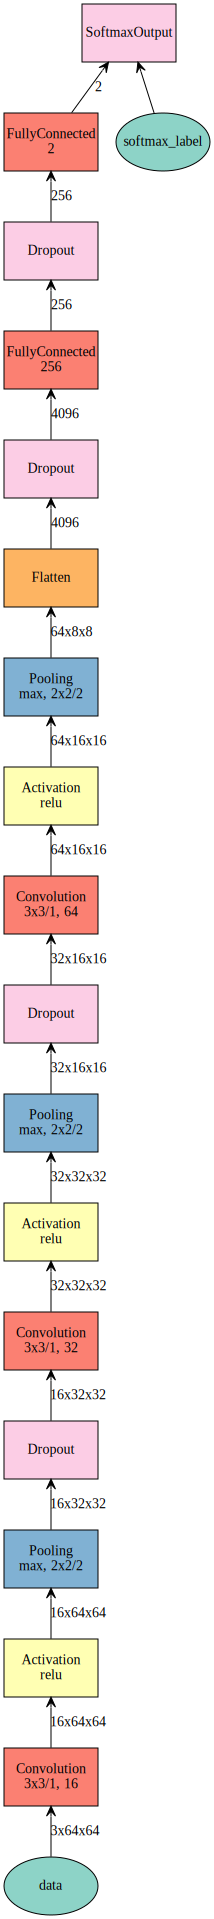

In [2]:
data = mx.sym.Variable('data')
conv1 = mx.sym.Convolution(data=data, kernel=(3, 3), pad=(1, 1), num_filter=16, name='conv1')
act1 = mx.sym.Activation(data=conv1, act_type='relu', name='relu1')
pool1 = mx.sym.Pooling(data=act1, pool_type='max', kernel=(2, 2), stride=(2, 2), name='pool1')

dp2 = mx.sym.Dropout(data=pool1, p=0, name='dp2')
conv2 = mx.sym.Convolution(data=dp2, kernel=(3, 3), pad=(1, 1), num_filter=32, name='conv2')
act2 = mx.sym.Activation(data=conv2, act_type='relu', name='relu2')
pool2 = mx.sym.Pooling(data=act2, pool_type='max', kernel=(2, 2), stride=(2, 2), name='pool2')

dp3 = mx.sym.Dropout(data=pool2, p=0, name='dp3')
conv3 = mx.sym.Convolution(data=dp3, kernel=(3, 3), pad=(1, 1), num_filter=64, name='conv3')
act3 = mx.sym.Activation(data=conv3, act_type='relu', name='relu3')
pool3 = mx.sym.Pooling(data=act3, pool_type='max', kernel=(2, 2), stride=(2, 2), name='pool3')

flt4 = mx.sym.Flatten(data=pool3, name='flt4')
dp4 = mx.sym.Dropout(data=flt4, p=0, name='dp4')
fc4 = mx.sym.FullyConnected(data=dp4, num_hidden=256, name='fc4')

dp5 = mx.sym.Dropout(data=fc4, p=0, name='dp5')
fc5 = mx.sym.FullyConnected(data=dp5, num_hidden=2, name='fc5')

mlp = mx.sym.SoftmaxOutput(data=fc5, name='softmax')

shape = {'data': (512, 3, 64, 64)}
mx.viz.plot_network(symbol=mlp, shape=shape)

## Train a classifier

In [3]:
def data_reader(cars, notcars, rand_state=1001):
    """helper function to read image data.
    """
    car_imgs = []
    notcar_imgs = []    
    for car in cars:
        img = plt.imread(car).transpose((2, 0, 1))
        car_imgs.append(img)
    for notcar in notcars:
        img = plt.imread(notcar).transpose((2, 0, 1))
        notcar_imgs.append(img)
    X = np.array(car_imgs + notcar_imgs)
    X[:,0,:] = X[:,0,:] - 0.313561
    X[:,1,:] = X[:,1,:] - 0.320951
    X[:,2,:] = X[:,2,:] - 0.311811
    y = np.array([1. for _ in range(len(cars))] + [0. for __ in range(len(notcars))])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=rand_state)
    return X_train, X_test, y_train, y_test

In [4]:
"Training here."
cars = glob.glob('./data/HOG/1/*/*.png')
notcars = glob.glob('./data/HOG/0/*/*.png')
X_train, X_test, y_train, y_test = data_reader(cars, notcars)
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size=200)
test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=200)

mod = mx.mod.Module(context=mx.gpu(0), symbol=mlp)
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params()
mod.init_optimizer(optimizer='adam')
mod.fit(train_iter, num_epoch=10)
mod.save_params('./weights')

In [8]:
mod = mx.mod.Module(context=mx.gpu(0), symbol=mlp)
mod.bind(data_shapes=test_iter.provide_data, label_shapes=test_iter.provide_label)
mod.load_params('./weights')
pred = mod.predict(test_iter).asnumpy().argmax(axis=1)
print("Testing Accuracy: %.4f"%(np.sum(np.equal(pred, y_test))/len(y_test)))

Testing Accuracy: 0.9916


## Define some helper functions for window searching

In [9]:
def slide_window(img_shape=(1280, 720), x_start_stop=(None, None), y_start_stop=(None, None),
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[0]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[1]
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


def draw_boxes(img, boxes, color=(0, 255, 0), thick=3):
    imcopy = np.copy(img)
    for boxp in boxes:
        for box in boxp:
            cv2.rectangle(imcopy, box[0], box[1], color, thick)
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for lst in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        for box in lst:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # ignore too small boxes
        if np.abs(bbox[0][0]-bbox[1][0])<50 or np.abs(bbox[0][1]-bbox[1][1])<50:
            continue
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 3)
    # Return the image
    return img


class Windows:
    
    def __init__(self, max_records, windows):
        self.records = []
        self.thresh = max_records
        self.all_windows = windows
        
    def search_windows(self, img, mod, belief_thresh):
        on_windows = []
        croped = []
        for window in self.all_windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], 
                                      window[0][0]:window[1][0]], (64, 64))
            test_img[:,:,0] -= 0.313561
            test_img[:,:,1] -= 0.320951
            test_img[:,:,2] -= 0.311811
            croped.append(test_img.transpose(2, 0, 1))
        croped = mx.io.NDArrayIter([croped], batch_size=100)
        preds = mod.predict(croped)
        preds = preds.asnumpy()[:,1]>belief_thresh
        t5 = time.time()
        for pred, window in zip(preds, self.all_windows):
            if pred:
                on_windows.append(window)
        self.records.append(on_windows)
        if len(self.records) > self.thresh:
            self.records.pop(0)

## Helper functions from Project4 for lane line tagging

In [10]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """calculate gradients horizontally or vertically 
    return a mask fitted in the threshold.
    """
    if orient=='x':
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.uint(sobel*255/np.max(sobel))
    grad_binary = np.zeros_like(gray)
    grad_binary[(sobel>thresh[0])&(sobel<thresh[1])] = 1
    return grad_binary


def hls_select(img, thresh=(0, 255)):
    """select color area fitted in the threshold in S channel. 
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>thresh[0])&(S<=thresh[1])] = 1
    return binary_output


def hsv_select(img, thresh):
    """helper function to select yellow and white areas.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(hsv, thresh['lower_white'], thresh['upper_white'])
    yellow_mask = cv2.inRange(hsv, thresh['lower_yellow'], thresh['upper_yellow'])
    hsv_binary = np.zeros_like(img[:,:,0])
    mask = (white_mask | yellow_mask)
    hsv_binary[mask>0] = 1
    return hsv_binary
    

def region_of_interest(img, vertices):
    """Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_curvature(img, L_line, R_line, cur_thresh=2000):
    """Function to draw curvature and position on the image.
    """
    curvature = min(L_line.radius_of_curvature, R_line.radius_of_curvature)
    if np.abs(curvature) > 2000:
        cv2.putText(img, 'The road is nearly straight.', (100, 100), 0, 1, (255, 255, 0), 2)
        cv2.putText(img, 'The car is %.2fm away from center.'%R_line.line_base_pos, (100, 140), 
                    0, 1, (255, 255, 0), 2)
    elif curvature < 0:
        cv2.putText(img, 'The lane curvature is %.2fm to the left.'%(-curvature), (100, 100), 
                    0, 1, (255, 255, 0), 2)
        cv2.putText(img, 'The car is %.2fm away from center.'%R_line.line_base_pos, (100, 140),  
                    0, 1, (255, 255, 0), 2)
    else:
        cv2.putText(img, 'The lane curvature is %.2fm to the right.'%curvature, (100, 100), 
                    0, 1, (255, 255, 0), 2)
        cv2.putText(img, 'The car is %.2fm away from center.'%R_line.line_base_pos, (100, 140), 
                    0, 1, (255, 255, 0), 2)
    return img
        
        
class Line:
    """The class for updating and keeping track of lane lines.
    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        self.fail_times = 0
        # x values of the last n fits of the line
        self.recent_xfitted = np.array([])       
        #average x values of the fitted line over the last n iterationsnum_records=3, diff_thresh=[1e-4, 1e-1, 60], max_fail=100
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = np.array([i for i in range(719, -1, -1)])
        
    def find_lane_lines(self, binary_img, centers, shift=100, y_start=160, step=90,
                        num_records=20, diff_thresh=[2e-4, 2e-1, 100], max_fail=40):
        """Calculate current lane line.
        """
        Xs, Ys = [], []
        for i, center in enumerate(centers):
            Y, X = np.where(binary_img[719-(i+1)*step:719-i*step, center-shift:center+shift]==1)
            if not X.any() or not Y.any() :
                continue
            X += center-shift
            Y += 719-(i+1)*step
            Xs.append(X)
            Ys.append(Y)
            
        if len(Xs)==0 and self.best_fit is not None:
            ws = self.best_fit
        elif len(Xs)==0:
            ws = np.array([0., 0., 0.])
        else:
            Xs = np.hstack(Xs)
            Ys = np.hstack(Ys)
            ws = np.polyfit(Ys, Xs, 2)
        
        if self.bestx is None:
            self.best_fit = ws
            self.current_fit = np.array([ws])
            self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                         + self.best_fit[2]).astype(np.int32)
            self.bestx = self.allx
            self.recent_xfitted = np.array([self.allx])
            self.calculate_curvature()
            return
        
        self.diffs = np.abs(ws - self.best_fit)
        if self.diffs[0]<diff_thresh[0] and self.diffs[1]<diff_thresh[1] and self.diffs[2]<diff_thresh[2]:
            self.detected = True
            if len(self.recent_xfitted) >= num_records:
                self.recent_xfitted = self.recent_xfitted[1:]
                self.current_fit = self.current_fit[1:]
        
            self.current_fit = np.vstack([self.current_fit, ws])
            self.best_fit = np.mean(self.current_fit, axis=0)
            self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                         + self.best_fit[2]).astype(np.int32)
            self.recent_xfitted = np.vstack([self.recent_xfitted, self.allx])
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            self.calculate_curvature()
            self.fail_times = 0
        elif self.best_fit[0] == 0. and self.best_fit[1] == 0. and self.best_fit[2] == 0.:
            self.best_fit = ws 
            self.current_fit = np.array([ws])
            self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                         + self.best_fit[2]).astype(np.int32)
            self.bestx = self.allx
            self.recent_xfitted = np.array([self.allx])
            self.calculate_curvature()
        else:
            self.detected = False
            self.fail_times += 1
            if self.fail_times > max_fail:
                self.fail_times = 0
                self.best_fit = ws  
                self.current_fit = np.array([ws])
                self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                             + self.best_fit[2]).astype(np.int32)
                self.bestx = self.allx
                self.recent_xfitted = np.array([self.allx])
                self.calculate_curvature()
        
    def calculate_curvature(self, ym_per_pix=30./720, xm_per_pix=3.7/700):
        """Calculate lane curvature and car position from the lane center.
        """
        X = self.allx * xm_per_pix
        Y = self.ally * ym_per_pix
        W = np.polyfit(Y, X, 2)
        y = np.max(Y)
        cur = ((1 + (2*W[0]*y + W[1])**2)**1.5)/2/W[0]
        self.radius_of_curvature = cur
        if X[0] > 650*xm_per_pix:
            self.line_base_pos = 950*xm_per_pix - X[0]
            

def draw_lane_lines(img, L_line, R_line, cfg):
    # to make sure the image shape is 1280*720 
    if img.shape[:-1] != [1280, 720]:
        img = cv2.resize(img, (1280, 720))
    # undistort the image.
    undist = cv2.undistort(img, cfg.mtx, cfg.dist)
    # apply color selection to the image
    hls_binary = hls_select(undist, cfg.hls_thresh)
    hsv_binary = hsv_select(undist, cfg.hsv_thresh)
    # apply gradient selection to the image
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    dx = abs_sobel_threshold(gray, 'x', 3, cfg.sobel_x_thresh)
    # combine them together
    binary = np.zeros_like(gray)
    binary[(dx==1)|(hsv_binary==1)|(hls_binary==1)] = 1
    binary = region_of_interest(binary, cfg.vertices)
    # transform perspective
    warped = cv2.warpPerspective(binary, cfg.M, (1280, 720), flags=cv2.INTER_LINEAR)
    # find centers for each step and use these centers to find lane lines
    L_centers = []
    R_centers = []
    for i in range(cfg.hist_start//cfg.hist_step):
        hist = np.sum(warped[719-(i+1)*cfg.hist_step:719-i*cfg.hist_step, :], axis=0)
        L_center = np.argmax(hist[:440])
        R_center = np.argmax(hist[840:]) + 840
        L_centers.append(L_center)
        R_centers.append(R_center)
    
    L_line.find_lane_lines(warped, L_centers, shift=cfg.L_shift, step=cfg.hist_step, 
                           num_records=cfg.L_num_records, diff_thresh=cfg.L_diff_thresh, 
                           max_fail=cfg.L_max_fail)
    R_line.find_lane_lines(warped, R_centers, shift=cfg.R_shift, step=cfg.hist_step, 
                           num_records=cfg.R_num_records, diff_thresh=cfg.R_diff_thresh, 
                           max_fail=cfg.R_max_fail)
    # plot the area between the detected two lines
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([L_line.allx, L_line.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([R_line.allx, R_line.ally])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # transform back
    newwarp = cv2.warpPerspective(color_warp, cfg.Minv, (1280, 720))
    lineImage = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # display curvature and position on the image
    lineImage = draw_curvature(lineImage, L_line, R_line)
    return lineImage

## Combined pipeline processing functions

In [11]:
def process_single_image(image, cfg, window, clf):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    window.search_windows(image, clf, cfg.belief_thresh)
    all_window_res = draw_boxes(draw_image, window.records)
    heatmap = np.zeros_like(draw_image[:,:,0])
    heatmap = add_heat(heatmap, window.records)
    thresh_heatmap = apply_threshold(heatmap, 1)
    labels = label(thresh_heatmap)               
    result = draw_labeled_bboxes(draw_image, labels)
    return result, all_window_res, thresh_heatmap, heatmap


def processing_image(image, L_line, R_line, cfg, window, clf):
    """image processing function for vedios.
    
    args:
        img, RGB image,
        L_line, left lane line, instance of Line class
        R_line, right lane line, instance of line class
        cfg, pipeline paramters, instance of Config class.
        window, instance of Windows class.
        clf, well-trained classifier.
    return:
        result, processed image.
    """
    lineImage = draw_lane_lines(image, L_line, R_line, cfg)
    image = image.astype(np.float32)/255
    window.search_windows(image, clf, cfg.belief_thresh)
    heatmap = np.zeros_like(image[:,:,0])
    heatmap = add_heat(heatmap, window.records)
    heatmap = apply_threshold(heatmap, cfg.heat_thresh)
    labels = label(heatmap)               
    result = draw_labeled_bboxes(lineImage, labels)
    return result

## Set parameters here

In [12]:
class LineConfig:
    # thresholds for color selection
    hls_thresh = (100, 255)
    hsv_thresh = {'lower_white': np.array([0, 0, 200]), 
                  'upper_white': np.array([100, 100, 255]), 
                  'lower_yellow': np.array([20, 80, 170]), 
                  'upper_yellow': np.array([120, 200, 255])
                 }
    # horizontal gradient thresholds
    sobel_x_thresh = (50, 100)
    # region of interests
    vertices = np.int32([[(203, 720), (585, 460), (730, 460), (1160, 720)]]) 
    # source points and destination points for transforming
    src = np.float32([(183, 720), (565, 460), (730, 460), (1160, 720)])
    dst = np.float32([(320, 720), (320,   0), (960,   0), ( 960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    hist_start = 450
    hist_step = 25
    L_shift = 50
    L_num_records = 10
    L_diff_thresh = [2e-4, 2e-1, 150]
    L_max_fail = 20
    R_shift = 50
    R_num_records = 10
    R_diff_thresh = [2e-4, 2e-1, 150]
    R_max_fail = 20 
    mtx = np.array([[1.15878631e+03, 0.00000000e+00, 6.65092774e+02],
                    [0.00000000e+00, 1.15560755e+03, 3.88726237e+02],
                    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    dist = np.array([[-0.26777569, 0.12307573, -0.00030252, 0.00058634, -0.2427864]])


class Config(LineConfig):
    
    def __init__(self):
        self.shape = (1280, 720)
        self.batch_size = 200
        # params for get_windows 
        self.x_start_stops = [[0,   1280], [250, 1280], [250, 1280], [700, 1280], [980, 1280]]
        self.y_start_stops = [[500,  670], [500,  670], [400,  550], [400,  500], [400,  600]]
        self.xy_windows    = [[120,  100], [100,   80], [70,    65], [70,    65], [100,   80]]
        self.overlaps      = [[0.5,  0.5], [0.5,  0.5], [0.6,  0.6], [0.6,  0.6], [0.5,  0.5]]
        self.windows = self.get_windows()
        # params for heapmap
        self.belief_thresh = 0.65
        self.max_records = 10
        self.heat_thresh = 12
        
    def get_windows(self):
        """method to find all interest windows according to the given regions.
        """
        all_windows = []
        for x, y, w, o in zip(self.x_start_stops, self.y_start_stops, self.xy_windows, self.overlaps):
            windows = slide_window(self.shape, x, y, w, o)
            all_windows += windows
        return all_windows

## Process single images

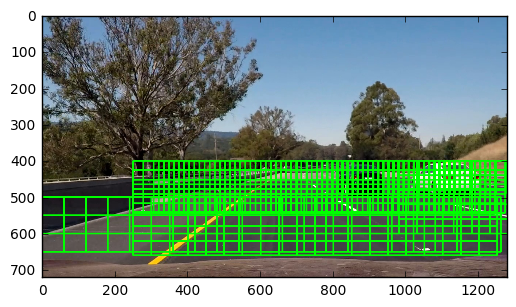

In [13]:
# Draw all searching boxes
cfg = Config()
all_boxes = draw_boxes(mpimg.imread('./test_images/968.jpg'), [cfg.windows])
plt.imshow(all_boxes)
plt.show()

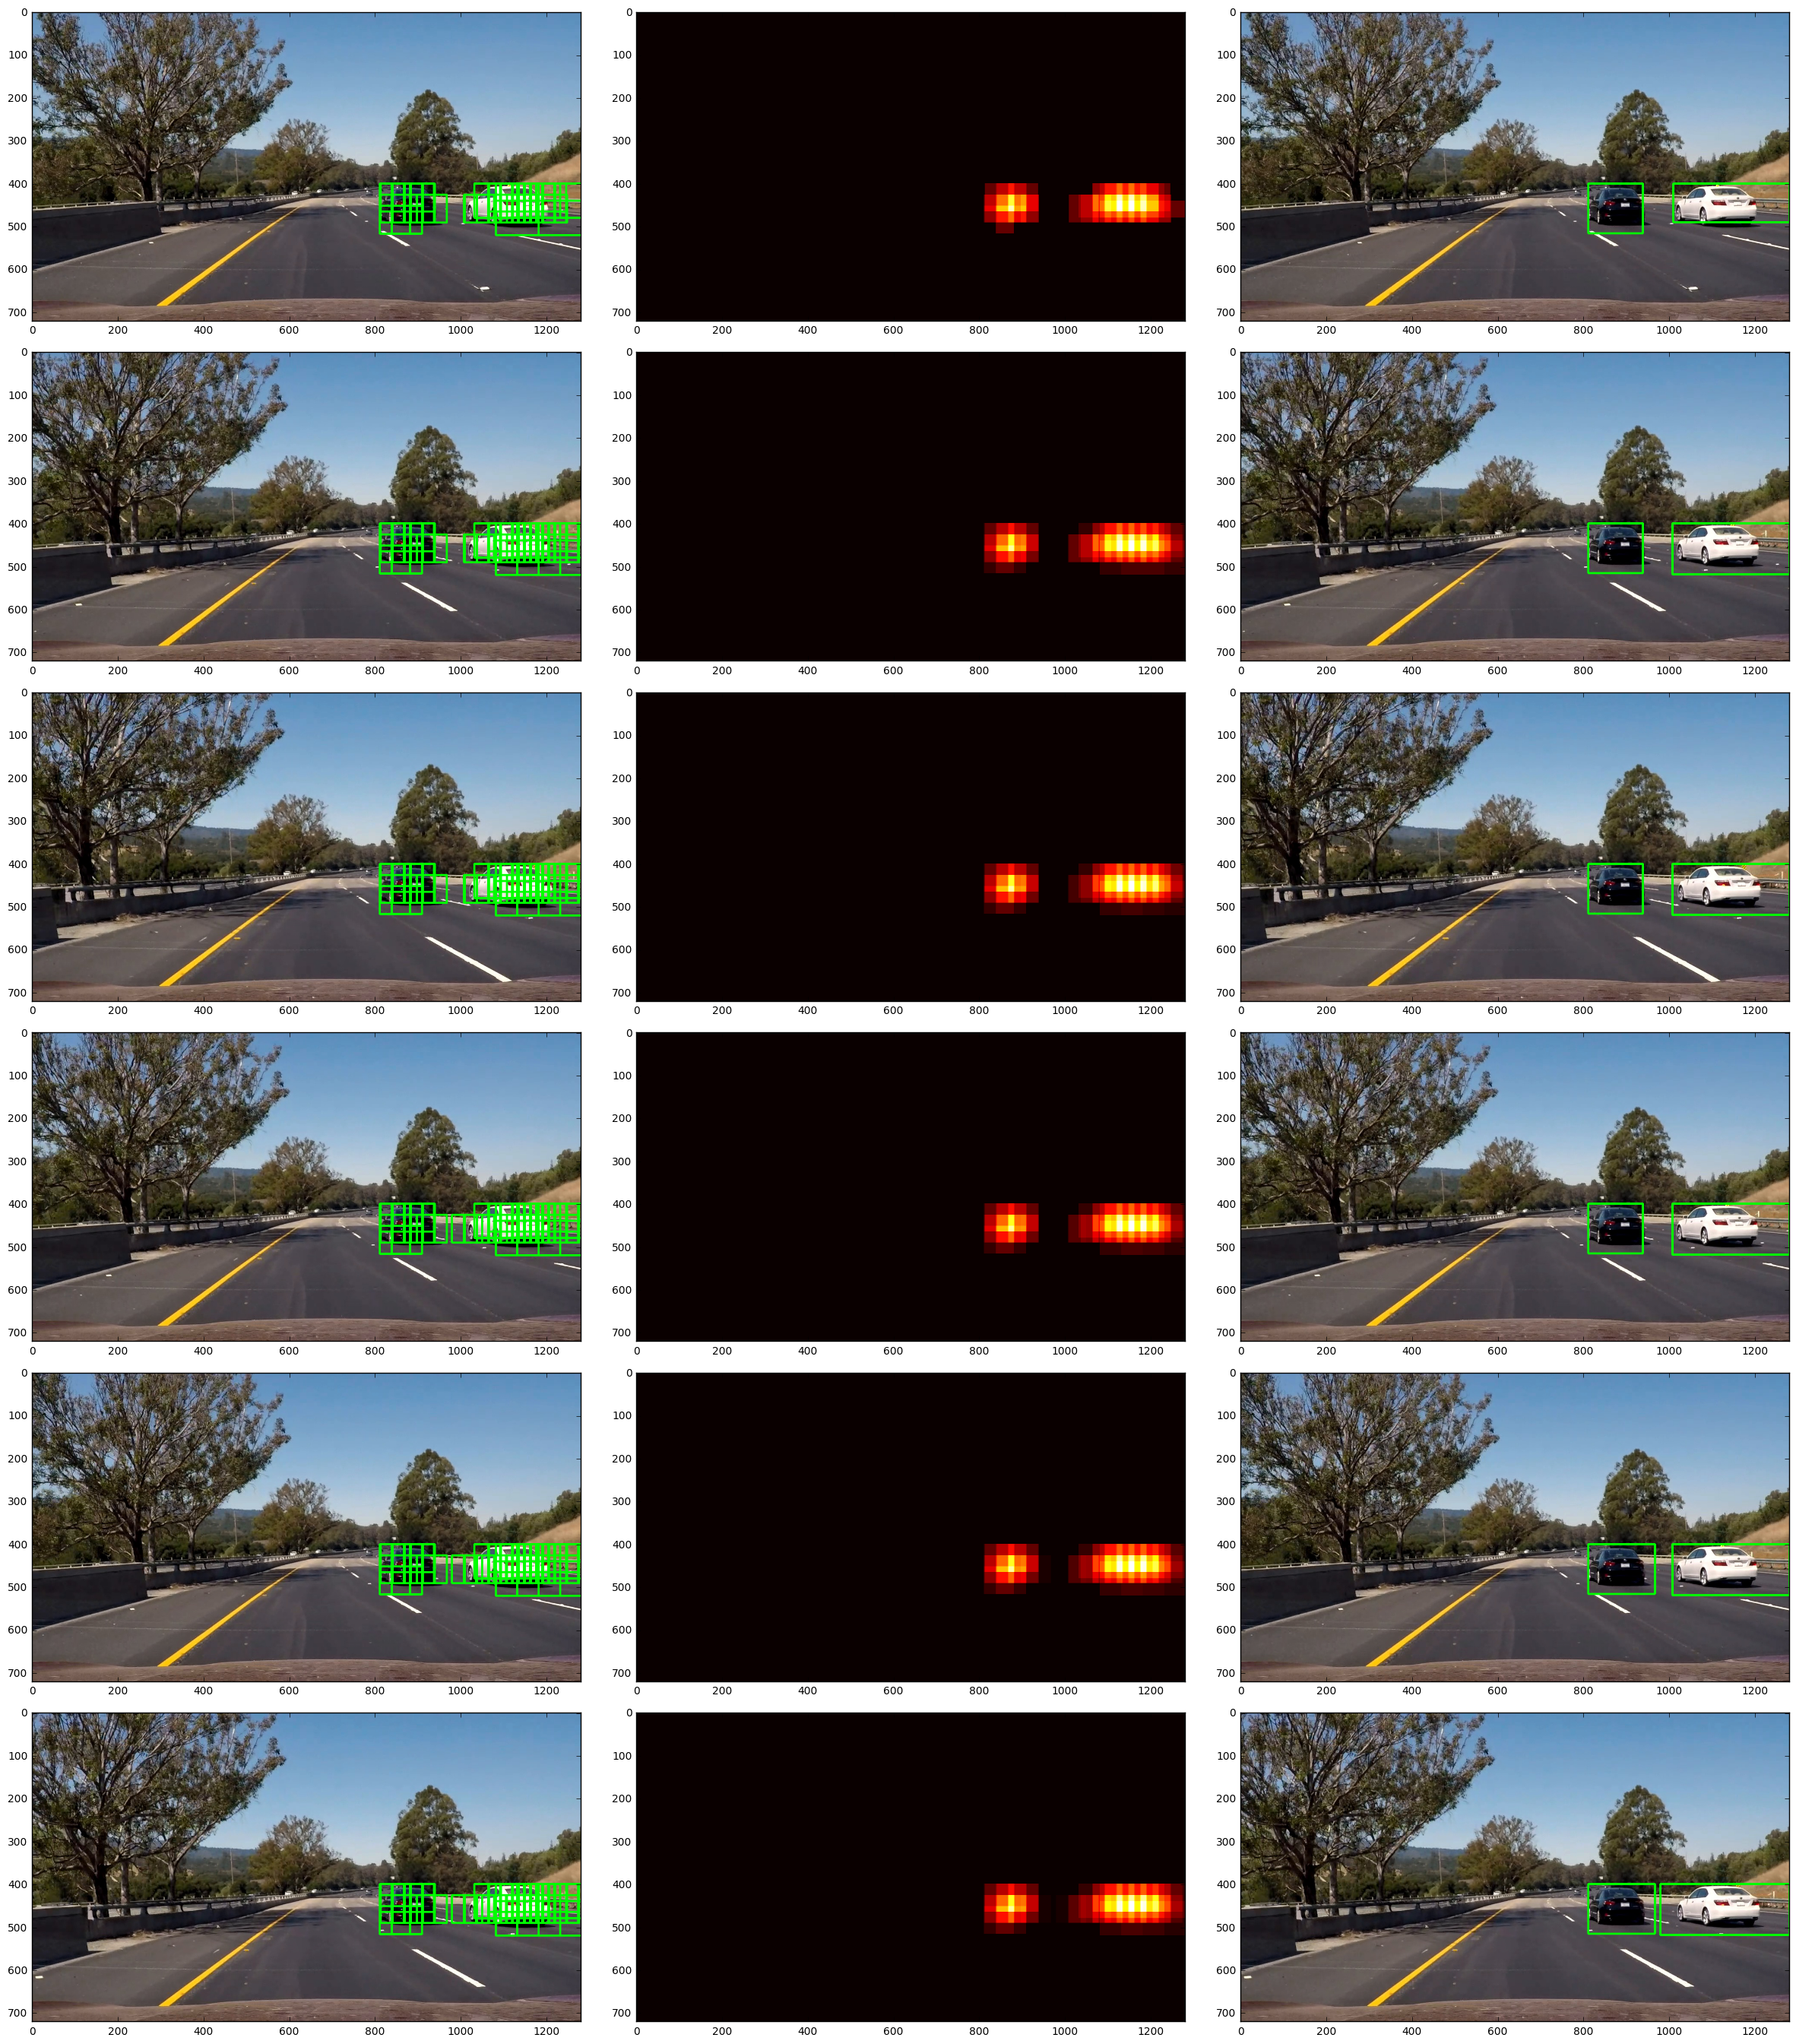

In [14]:
# Process test images here
cfg.heat_thresh = 8
cfg.max_records = 6
clf = mx.mod.Module(context=mx.gpu(0), symbol=mlp)
window = Windows(cfg.max_records, cfg.windows)
clf.bind(data_shapes=[('data', (100, 3, 64, 64))], 
         label_shapes=[('softmax_label', (100, 2))])
clf.load_params('./weights')

f, ax = plt.subplots(6, 3, figsize=(24,27))
f.tight_layout()
test_imgs = './test_images/'
for i, img in enumerate(os.listdir(test_imgs)):
    img = mpimg.imread(test_imgs+img)
    result, all_window_res, thresh_heatmap, heatmap = process_single_image(img, cfg, window, clf)
    ax[i][0].imshow(all_window_res)
    ax[i][1].imshow(thresh_heatmap, 'hot')
    ax[i][2].imshow(result)
plt.show()

## Process video stream here

In [ ]:
output = 'project_video_ans.mp4'
clip1 = VideoFileClip("project_video.mp4")
cfg = Config()
L_line = Line()
R_line = Line()
window = Windows(cfg.max_records, cfg.windows)
processing = lambda image: processing_image(image, L_line, R_line, cfg, window, clf)
res_clip = clip1.fl_image(processing) 
%time res_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_ans.mp4
[MoviePy] Writing video project_video_ans.mp4


 89%|████████▊ | 1116/1261 [02:06<00:17,  8.39it/s]    | 1/1261 [00:00<02:38,  7.94it/s]

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))